# **Instructions:**
There are no correct or wrong answers to this assignment.
Please immerse yourself into the role of an Anti-Fraud Analyst (whatever it means for you), and demonstrate via the use of code and comments
your abilities and approaches to data exploration, modeling, and investigation. You may write a summary of your findings at the end of your
file submission, as well as proposals to any (if there are any) fraudulent patterns you are able to detect.
In the event that you have any follow up questions or need for clarifications, feel free to contact the email address from which you have 
received this assignment.

Please find attached 2 csv files:
AntiFraudAnalystTradeData.csv - contains all trades of a specific time period, from the point of the view of the user (i.e. positive pnl = user profit)
AntiFraudAnalystUserDevices.csv - contains all available device ids of users who traded in this time period

In [1]:
import pandas as pd
import numpy as np

In [2]:
import datetime
from datetime import datetime

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (5, 3)

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
df_trade = pd.read_csv('AntiFraudAnalystTradeData.csv')
df_ids = pd.read_csv('AntiFraudAnalystUserDevices.csv')

#### **Columns:**  
id - unique id of the trade  
user_id - unique id of the user  
registration_date - registration date of the user  
fin_instrument - financial asset name of the underlying  
instrument_type - type of option instrument  
instrument_direction - put/call direction of the trade  
create_at - time of trade open  
close_at - time of trade close  
instrument_expiration - maturity time of option product  
close_reason - reason for closing the position  
platform - type of device platform trade was executed on  
open_quote - market quote at time of open  
close_quote - market quote at time of close  
instrument_strike - strike of the option instrument  
initial_investment_enrolled - dollar amount of investment  
pnl_total_enrolled - dollar amount of profit/loss  
#------------------------------------------------------------  
user_id - unique id of the user  
device_id - unique id of the user's device

## **Plan to resolve the task:**  

1. Run some analysis (EDA) for data.
2. ML modeling: Re-format and fill in with new features the data with trades with the focus on following features which may be crucial to determine fraud:  
   a) number of devices per user,  
   b) accounts using same devices,  
   c) number of trades by user,  
   d) total pnl by user,  
   e) count of calls and puts by user,  
   f) count of option types (turbo, digital) by user,  
   g) count of platforms used by a user,  
   h) count of wins vs. losses by a user,  
   i) total investment by a user,
   j) number of trades at different time periods of trade activities.   
3. Run Cluster analysis and make conclusions.

In [6]:
df_trade.head(2)

,Unnamed: 0,id,user_id,registration_date,fin_instrument,instrument_type,instrument_direction,create_at,close_at,instrument_expiration,close_reason,platform,open_quote,close_quote,instrument_strike,initial_investment_enrolled,pnl_total_enrolled
0,0,9653594472,585118157,2019-04-05 17:12:46.000000,XRPUSD,turbo-option,call,2022-06-17 19:41:03.216000+00:00,2022-06-17 19:42:00+00:00,2022-06-17 19:42:00+00:00,expired,Unknown platform,0.314705,0.314955,0.314705,22.61,19.21
1,1,9641975390,1456695825,2021-08-12 02:28:57.928101,XRPUSD,turbo-option,call,2022-06-14 00:23:15.137000+00:00,2022-06-14 00:24:00+00:00,2022-06-14 00:24:00+00:00,expired,WebGL,0.308125,0.307895,0.308125,0.39,-0.39


In [7]:
df_ids.head(2)

,Unnamed: 0,user_id,device_id
0,0,1185175017,a3037561a43a726fdbd4168b4e2e7df7
1,1,1245468614,92e5e634-9d56-4aa9-9dd3-9cca03da117e


In [8]:
df_trade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1764494 entries, 0 to 1764493
Data columns (total 17 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Unnamed: 0                   int64  
 1   id                           int64  
 2   user_id                      int64  
 3   registration_date            object 
 4   fin_instrument               object 
 5   instrument_type              object 
 6   instrument_direction         object 
 7   create_at                    object 
 8   close_at                     object 
 9   instrument_expiration        object 
 10  close_reason                 object 
 11  platform                     object 
 12  open_quote                   float64
 13  close_quote                  float64
 14  instrument_strike            float64
 15  initial_investment_enrolled  float64
 16  pnl_total_enrolled           float64
dtypes: float64(5), int64(3), object(9)
memory usage: 228.9+ MB


In [9]:
df_ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6245842 entries, 0 to 6245841
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   Unnamed: 0  int64 
 1   user_id     int64 
 2   device_id   object
dtypes: int64(2), object(1)
memory usage: 143.0+ MB


In [10]:
# as 'Unnamed: 0' columns just repeat indexes let's remove them 
df_trade.drop('Unnamed: 0', axis = 1, inplace = True)
df_ids.drop('Unnamed: 0', axis = 1, inplace = True)

In [11]:
df_trade.isna().sum()

id                             0
user_id                        0
registration_date              0
fin_instrument                 0
instrument_type                0
instrument_direction           0
create_at                      0
close_at                       0
instrument_expiration          0
close_reason                   0
platform                       0
open_quote                     0
close_quote                    0
instrument_strike              0
initial_investment_enrolled    0
pnl_total_enrolled             0
dtype: int64

In [12]:
df_ids.isna().sum()

user_id      0
device_id    0
dtype: int64

In [13]:
df_trade['registration_date'] = pd.to_datetime(df_trade['registration_date'])
df_trade['close_at'] = pd.to_datetime(df_trade['close_at'], format='mixed')
df_trade['create_at'] = pd.to_datetime(df_trade['create_at'], format='mixed')
df_trade['instrument_expiration'] = pd.to_datetime(df_trade['instrument_expiration'])

In [14]:
df_trade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1764494 entries, 0 to 1764493
Data columns (total 16 columns):
 #   Column                       Dtype              
---  ------                       -----              
 0   id                           int64              
 1   user_id                      int64              
 2   registration_date            datetime64[ns]     
 3   fin_instrument               object             
 4   instrument_type              object             
 5   instrument_direction         object             
 6   create_at                    datetime64[ns, UTC]
 7   close_at                     datetime64[ns, UTC]
 8   instrument_expiration        datetime64[ns, UTC]
 9   close_reason                 object             
 10  platform                     object             
 11  open_quote                   float64            
 12  close_quote                  float64            
 13  instrument_strike            float64            
 14  initial_investment

Let's investigate the number of unique user_ids in both sets ...

In [15]:
df_trade['user_id'].nunique()

81726

In [16]:
df_ids['user_id'].nunique()

81006

In [17]:
len(list(set(list(df_trade['user_id'].unique()))-set(list(df_ids['user_id'].unique()))))

720

In [18]:
len(list(set(list(df_ids['user_id'].unique()))-set(list(df_trade['user_id'].unique()))))

0

In [19]:
round(720/81726*100,2)

0.88

##### **Finding:**  
in df_trade there are more unique user_ids and 720 users in df_trade will be without the total number of used devices as I plan to join two datasets. From another side, 720 is less than 1% of total number of users, so the records for the users may be deleted if no significant impact on overall results will happen. To stay with those users I will equalize number of devices to 0s for those 720 users id. Then, more investigation will be executed.

### Let's investigate df_ids dataset.

In [20]:
# number of devices per a user
n_devices_per_user = df_ids.groupby('user_id', as_index=False).count().sort_values(
    'device_id', ascending=False).rename(columns = {'device_id':'n_devices'})
n_devices_per_user.reset_index(drop = True, inplace = True)

In [21]:
n_devices_per_user.head(3)

,user_id,n_devices
0,739862968,17359
1,1263693067,15279
2,583977446,14004


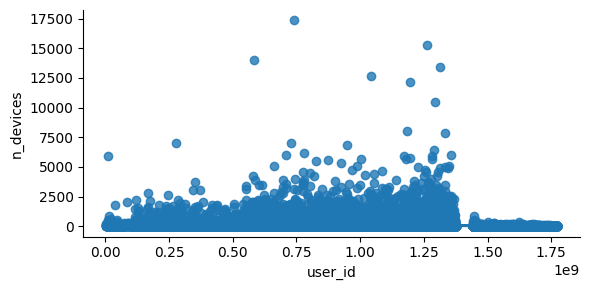

In [22]:
# there are some outliers above 2500 n_devices  /user
sns.lmplot(data = n_devices_per_user, x = 'user_id', y = 'n_devices', height = 3, aspect =2)
plt.show()

#### Visually, it looks 2500 number divides user_id outliers from the most of user_ids. let's calculate the share of devices at outliers vs. the total number of devices.

In [23]:
round(100*n_devices_per_user.query('n_devices > 2500')['n_devices'].sum()/n_devices_per_user['n_devices'].sum(),1)

9.9

In [24]:
n_devices_per_user.query('n_devices > 2500')['n_devices'].count()

146

In [25]:
round(100*n_devices_per_user.query('n_devices > 2500')['n_devices'].count()/n_devices_per_user['n_devices'].count(),1)

0.2

**Findings:**  
a) The impact on number of devices from those outliers is 10% vs. the total number  
b) But, the impact is provided by just 146 users that is only 0.2% of all users in the dataset.

Those users are not physical people but companies providing the service or this is sign of fraud?

#### Let's analyze how many users use 1, 2, 3 ... devices

In [26]:
n_users_per_ndev = n_devices_per_user.groupby('n_devices', as_index=False).count().sort_values(
    'user_id', ascending = False).rename(columns = {'user_id':'n_users'})
n_users_per_ndev.reset_index(drop = True, inplace = True)

In [27]:
n_users_per_ndev.head(3)

,n_devices,n_users
0,3,5954
1,2,5853
2,4,5532


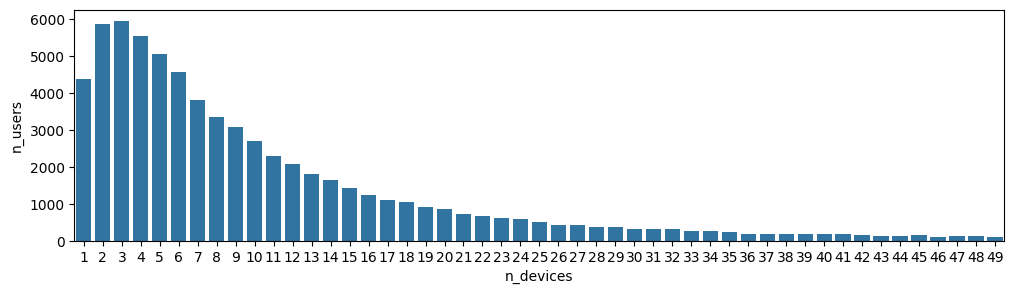

In [28]:
plt.figure(figsize = (12,3))
sns.barplot(data = n_users_per_ndev.query('n_devices < 50'), x = 'n_devices', y = 'n_users')
plt.show()

**Findings:**  
a) Usage of 3 devices and then 2 devices are the most frequent cases.  
b) Then, the distribution of n_users by number of devices declines smoothly.

**Thoughts & Question:**  
I can assume what reasons (different gadgets, new ones, trading from corporate computer ...) are behind the number of devices used by a user from 2 to 5 and even up to 5-10 devices but by now it's not clear what reason is behind usage of 10+ devices by a user except the cases mentioned above ... 

#### Do we have different users using same devices?

In [29]:
df_same_dev = df_ids.groupby('device_id', as_index=False).count().sort_values('user_id', ascending = False).reset_index(drop = True)
df_same_dev.rename(columns = {'user_id':'n_users_same_dev'}, inplace = True)
df_same_dev.head()

,device_id,n_users_same_dev
0,3cced232-d792-40e3-bdc7-ddff4ac02693,133
1,08000000-0000-0000-0000-000000000000,121
2,PtX2Y9zTfhULD7QHCr07,68
3,3BC2D0F6-0DFE-5A64-BF98-31810536B53E,67
4,66210d5f-a85d-4e60-bae8-cb68de27029f,52


This is strange that many different users use same devices ... that can be sign of fraud.  

Let's mark users using same devices together with number of devices per user at the final dataframe to be used for ML analysis 

In [30]:
temp = df_ids.merge(df_same_dev, how = 'left', on = 'device_id')

In [31]:
temp = temp.groupby('user_id', as_index=False).agg({'device_id':'count', 'n_users_same_dev':'unique'})
temp['n_users_same_dev'] = temp['n_users_same_dev'].apply(lambda x: x[0])
temp.rename(columns = {'device_id':'n_devices'}, inplace = True)

In [32]:
temp.head()

,user_id,n_devices,n_users_same_dev
0,2352922,9,1
1,2850718,149,1
2,3283384,11,1
3,3726424,64,1
4,3994731,1,6


#### At temp dataframe we can see number of devices used by each user_id and number of user_id(s) using same device_id. For example, user_id = 3994731 use the same device_id used by another 5 user_id(s), so, totally, same device_is is used by 6 different accounts.

#### Let's analyze the distribution of trades by hour

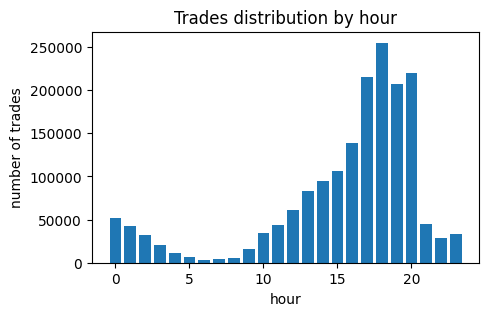

In [33]:
df_trade['hour'] = df_trade['create_at'].dt.hour
counts = df_trade.groupby('hour')['id'].count()
plt.bar(counts.index, counts.values)
plt.xlabel('hour')
plt.ylabel('number of trades')
plt.title('Trades distribution by hour')
plt.show()

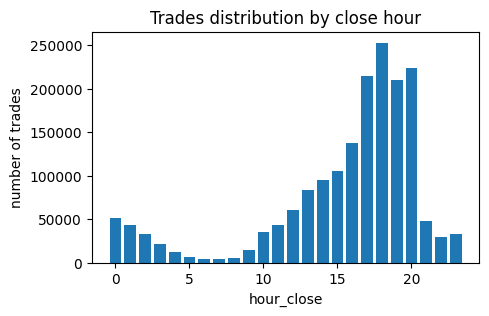

In [34]:
df_trade['hour_close'] = df_trade['close_at'].dt.hour
counts = df_trade.groupby('hour_close')['id'].count()
plt.bar(counts.index, counts.values)
plt.xlabel('hour_close')
plt.ylabel('number of trades')
plt.title('Trades distribution by close hour')
plt.show()

#### **Findings:**  
a) There is no visual difference between create_at and close_at as expected as we deal with short-term options,  
b) The most active hours for trading are from 12 to 20 hours (actually, from 12:00 till 20:59),  
c) Next activity level can be observed at the periods from 0:00 till 4:59 (df.hours from 0 to 4),  
d) Almost "silence" period is from 5:00 till 8:59 (df.hours from 5 to 8),  

Further I will add the column with the characteristics for every trade showing above levels of trade activity: 3 for high, 2 for middle, 1 for low for fraud analysis as some fraud trades can be executed when the activity is low and low attention from supervisors exists. Afterhand I will count for each user how many trades were executed at high-level period, middle-level and low-level-periods.

In [35]:
high_act = [12, 13, 14, 15, 16, 17, 18, 19, 20]
middle_act = [0, 1, 2, 3, 4, 9, 10, 11, 21, 22, 23]
low_act = [5, 6, 7, 8]

In [36]:
df_trade['act_level'] = df_trade['hour'].apply(lambda x: 3 if x in high_act else 2 if x in middle_act else 1)

In [37]:
del df_trade['hour'], df_trade['hour_close']

In [38]:
# just to see some statistics
for i in list(df_trade.columns):
    print(f"{i:25}\tNumber of unique items:{df_trade[i].nunique():7}\t % of total rows:{round(100*df_trade[i].nunique()/df_trade.shape[0],1):6}%")

id                       	Number of unique items:1764494	 % of total rows: 100.0%
user_id                  	Number of unique items:  81726	 % of total rows:   4.6%
registration_date        	Number of unique items:  81726	 % of total rows:   4.6%
fin_instrument           	Number of unique items:      5	 % of total rows:   0.0%
instrument_type          	Number of unique items:      2	 % of total rows:   0.0%
instrument_direction     	Number of unique items:      2	 % of total rows:   0.0%
create_at                	Number of unique items:1736398	 % of total rows:  98.4%
close_at                 	Number of unique items: 104679	 % of total rows:   5.9%
instrument_expiration    	Number of unique items:  17980	 % of total rows:   1.0%
close_reason             	Number of unique items:      3	 % of total rows:   0.0%
platform                 	Number of unique items:     20	 % of total rows:   0.0%
open_quote               	Number of unique items: 577557	 % of total rows:  32.7%
close_quote     

#### Let's have a look at categorical features:

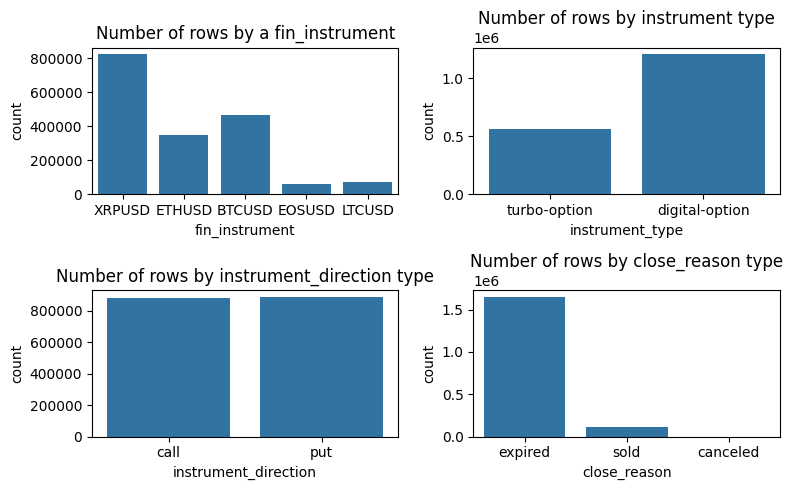

In [39]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(8,5))
sns.countplot(data = df_trade, x = 'fin_instrument', ax = axes[0,0])
axes[0,0].set_title('Number of rows by a fin_instrument')
sns.countplot(data = df_trade, x = 'instrument_type', ax = axes[0,1])
axes[0,1].set_title('Number of rows by instrument type')
sns.countplot(data = df_trade, x = 'instrument_direction', ax = axes[1,0])
axes[1,0].set_title('Number of rows by instrument_direction type')
sns.countplot(data = df_trade, x = 'close_reason', ax = axes[1,1])
axes[1,1].set_title('Number of rows by close_reason type')
plt.tight_layout()
plt.show()

**Findings:**  
a) The biggest number of trades was executed with XRPUSD.  
b) Digital options were more popular vs. turbo options.  
c) Numbers of call and put options were almost the same.

In [40]:
from collections import Counter
counter = Counter(df_trade.platform)
order = [value[0] for value in counter.most_common()]#[::-1]

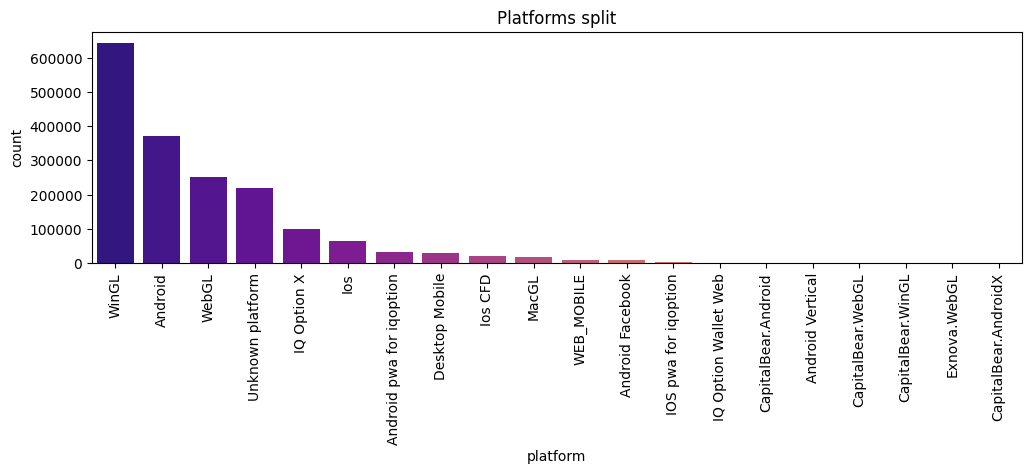

In [41]:
plt.figure(figsize = (12,3))
sns.countplot(data = df_trade, x = 'platform', order = order, palette = 'plasma')
plt.xticks(rotation = 90)
plt.title('Platforms split')
plt.show()

**Findings:**  
a) Top 3 platforms are WinGL, Android, WebGL.  
b) Unknown platform is in 4th place.

### Let's merge temp dataframe with number of devices and numbers of user_id(s) using same devices with df_trade and investigate new dataframe

In [42]:
df = df_trade.merge(temp, how = 'left', on = 'user_id')

In [43]:
df.head(3)

,id,user_id,registration_date,fin_instrument,instrument_type,instrument_direction,create_at,close_at,instrument_expiration,close_reason,platform,open_quote,close_quote,instrument_strike,initial_investment_enrolled,pnl_total_enrolled,act_level,n_devices,n_users_same_dev
0,9653594472,585118157,2019-04-05 17:12:46.000000,XRPUSD,turbo-option,call,2022-06-17 19:41:03.216000+00:00,2022-06-17 19:42:00+00:00,2022-06-17 19:42:00+00:00,expired,Unknown platform,0.314705,0.314955,0.314705,22.610000,19.210000,3,21.0,1.0
1,9641975390,1456695825,2021-08-12 02:28:57.928101,XRPUSD,turbo-option,call,2022-06-14 00:23:15.137000+00:00,2022-06-14 00:24:00+00:00,2022-06-14 00:24:00+00:00,expired,WebGL,0.308125,0.307895,0.308125,0.390000,-0.390000,2,15.0,1.0
2,15634194734,220188644,2017-03-25 01:22:50.000000,XRPUSD,digital-option,call,2022-06-13 20:18:13.091000+00:00,2022-06-13 20:19:00+00:00,2022-06-13 20:19:00+00:00,expired,WinGL,0.323725,0.323695,0.323725,0.391288,-0.391288,3,351.0,1.0


In [44]:
# let's replace all NaN in the columns: n_devices and n_users_same_dev by 0s as we don't have the info about 720 user ids.
df['n_devices'].fillna(0, inplace=True)
df['n_users_same_dev'].fillna(0, inplace=True)

#### Let's investigate pnl and number of wins (profitable trades) vs losses

In [45]:
temp = df[['user_id','pnl_total_enrolled']].sort_values('pnl_total_enrolled', ascending = False)
temp['win'] = temp['pnl_total_enrolled'].apply(lambda x: 1 if x>0 else -1) # assign 1 for positive trade and -1 for negative trade
temp = temp.groupby('user_id', as_index = False).agg({'pnl_total_enrolled':'sum', 'win':'sum'}).rename(columns = {'pnl_total_enrolled':'pnl_total', 'win':'n_wins'})

In [46]:
temp[['pnl_total','n_wins']].describe()

,pnl_total,n_wins
count,81726.000000,81726.000000
mean,12.957315,0.621344
std,359.739658,23.896946
min,-3215.437469,-4972.000000
25%,-2.701822,-2.000000
50%,-0.374824,0.000000
75%,1.640278,2.000000
max,25270.761223,1402.000000


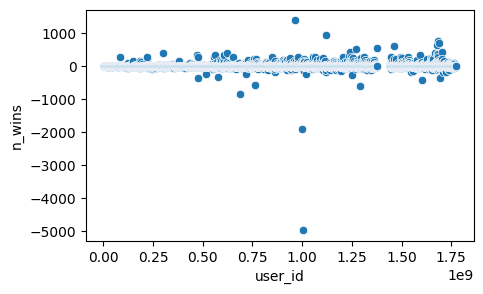

In [47]:
sns.scatterplot(data = temp, x = 'user_id', y = 'n_wins')
plt.show()

#### **Findings:**  
a) there are clear outliers with number of wins and total pnl above 75% percentile.  
b) The most of users in terms of number of wins (sum of 1s and -1s) are between -2 and 2.  
b) It's interesting that 75% percentile of pnl_total is less than 25% percentile in absolute value that may say that there are some users with very high earnings.

## 2. ML Modeling: adding new features.

#### Let's add as extra column numbers of trades by a user.

In [48]:
df = df.merge(df.groupby('user_id', as_index = False).agg({'id':'count'}).\
        sort_values('id', ascending = False).rename(columns = {'id':'n_trades'}), how = 'left', on = 'user_id')

#### Let's add count of used calls and puts by a user as extra column and replace NaNs by 0s.

In [49]:
df = df.merge(df.query('instrument_direction == "put"').groupby('user_id', as_index = False)['id'].count().\
        rename(columns = {'id':'n_put'}), how = 'left', on = 'user_id')
df = df.merge(df.query('instrument_direction == "call"').groupby('user_id', as_index = False)['id'].count().\
        rename(columns = {'id':'n_call'}), how = 'left', on = 'user_id')
df['n_put'].fillna(0, inplace=True)
df['n_call'].fillna(0, inplace=True)

#### Let's add count of used instrument types by a user as extra column and replace NaNs by 0s.

In [50]:
df = df.merge(df.query('instrument_type == "turbo-option"').groupby('user_id', as_index = False)['id'].count().\
        rename(columns = {'id':'n_turbo'}),  how = 'left', on = 'user_id')
df = df.merge(df.query('instrument_type == "digital-option"').groupby('user_id', as_index = False)['id'].count().\
        rename(columns = {'id':'n_digital'}),  how = 'left', on = 'user_id')
df['n_turbo'].fillna(0, inplace=True)
df['n_digital'].fillna(0, inplace=True)

#### Let's add count of used platforms by a user as extra column and replace NaNs by 0s.

In [51]:
ls_pl = list(df.platform.unique())

In [52]:
for i in ls_pl:
    df = df.merge(df.query('platform == @i').groupby('user_id', as_index = False)['id'].count().\
        rename(columns = {'id':'n_'+i}), how = 'left', on = 'user_id')
    df['n_'+i].fillna(0, inplace=True)

#### Let's add pnl_total and count of wins vs losses by a user from the temp dataframe above as extra column and replace NaNs by 0s.

In [53]:
df = df.merge(temp, how = 'left', on = 'user_id')
df['pnl_total'].fillna(0, inplace=True)
df['n_wins'].fillna(0, inplace=True)

#### Let's add total investment by a user as extra column.

In [54]:
df = df.merge(df.groupby('user_id', as_index = False).agg({'initial_investment_enrolled':'sum'}).\
sort_values('initial_investment_enrolled', ascending = False).rename(columns = {'initial_investment_enrolled':'total_investment'}),\
              how = 'left', on = 'user_id')
df['total_investment'].fillna(0, inplace=True)

#### Let's calculate the number of trade as per Activity level by a user as extra column and replace NaNs by 0s

In [55]:
df = df.merge(df.groupby('user_id', as_index = False).agg({'act_level':'count'}).\
        rename(columns = {'act_level':'n_act_level'}), how = 'left', on = 'user_id')
df['n_act_level'].fillna(0, inplace=True)

#### Let's add also a year of registration ... may be, there is some dependency on it

In [56]:
df['reg_year'] = df['registration_date'].dt.year

#### Preliminary dataframe with user_id and only needed features

In [58]:
df = df[['user_id', 'n_act_level', 'n_devices', 'n_users_same_dev',
       'n_trades', 'n_put', 'n_call', 'n_turbo', 'n_digital',
       'n_Unknown platform', 'n_WebGL', 'n_WinGL', 'n_Desktop Mobile',
       'n_Android', 'n_IQ Option X', 'n_WEB_MOBILE', 'n_Ios',
       'n_Android pwa for iqoption', 'n_MacGL', 'n_Ios CFD',
       'n_Android Facebook', 'n_IQ Option Wallet Web', 'n_Android Vertical',
       'n_CapitalBear.Android', 'n_IOS pwa for iqoption',
       'n_CapitalBear.WebGL', 'n_CapitalBear.WinGL', 'n_Exnova.WebGL',
       'n_CapitalBear.AndroidX', 'pnl_total', 'n_wins', 'total_investment',
       'reg_year']]

#### We need to drop duplicates as we added features for every repeating row with user_id

In [60]:
df.drop_duplicates(inplace = True)

In [62]:
df.info() # no NaNs and no objects. Number of rows is equal to the number of unique user_id(s)

<class 'pandas.core.frame.DataFrame'>
Index: 81726 entries, 0 to 1764481
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     81726 non-null  int64  
 1   n_act_level                 81726 non-null  int64  
 2   n_devices                   81726 non-null  float64
 3   n_users_same_dev            81726 non-null  float64
 4   n_trades                    81726 non-null  int64  
 5   n_put                       81726 non-null  float64
 6   n_call                      81726 non-null  float64
 7   n_turbo                     81726 non-null  float64
 8   n_digital                   81726 non-null  float64
 9   n_Unknown platform          81726 non-null  float64
 10  n_WebGL                     81726 non-null  float64
 11  n_WinGL                     81726 non-null  float64
 12  n_Desktop Mobile            81726 non-null  float64
 13  n_Android                   81726 

In [63]:
df.reset_index(drop = True, inplace = True) # to fix the mess with indexes

In [64]:
X = df.drop('user_id', axis = 1)

In [65]:
from sklearn.preprocessing import MinMaxScaler

In [66]:
scaler = MinMaxScaler()

In [67]:
X_scaled = scaler.fit_transform(X)

In [68]:
from sklearn.cluster import KMeans

KMeans will minimize the sum of squared distances between objects of clusters and their centroids, the value is found in the inertia_. Let's calculate inertia values for different number of clusters. It should eager to some minimal value, ideally, to 0).

In [69]:
k_inertia = []
ks = range(1,11)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(X_scaled, )
    k_inertia.append(clf_kmeans.inertia_)

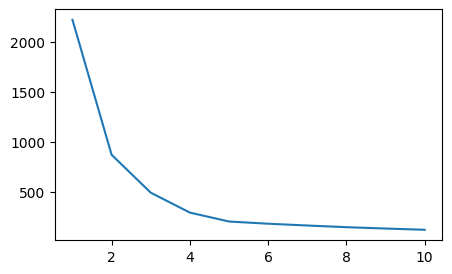

In [70]:
plt.plot(ks, k_inertia)

In [71]:
k_inertia

[2224.4825245076477,
 872.5703319051981,
 493.2861308098436,
 293.6627235522004,
 204.40631488843033,
 182.5069490216692,
 164.46789680869358,
 147.62509424480012,
 134.10226309386485,
 121.70883367178112]

#### Let's choose optimal number of clusters as per change for k_inertia vs. previous value

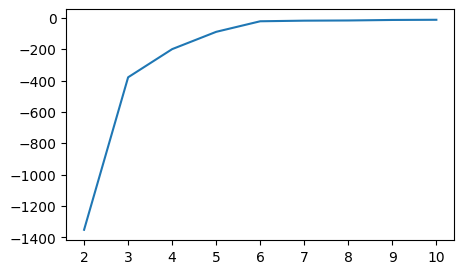

In [72]:
diff = np.diff(k_inertia)
plt.plot(ks[1:], diff)

#### We will use the formula below to find the optimal number

$$k_{opt} = argmin(\frac{inertia_{k+1}-inertia_{k}}{inertia_{k}-inertia_{k-1}})$$

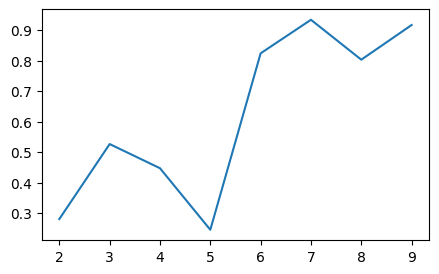

In [74]:
diff_r = diff[1:] / diff[:-1]
plt.plot(ks[1:-1], diff_r)
plt.show()

In [75]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

5

In [76]:
kmeans = KMeans(n_clusters = 5)
kmeans.fit(X_scaled)

KMeans(n_clusters=5)

In [77]:
df['cluster'] = kmeans.labels_

In [90]:
for i in list(df.cluster.sort_values().unique()):
    print(f"Cluster {i} has {df.query('cluster == @i').shape[0]} users")

Cluster 0 has 26625 users
Cluster 1 has 8360 users
Cluster 2 has 24472 users
Cluster 3 has 19814 users
Cluster 4 has 2455 users


In [108]:
centroids = kmeans.cluster_centers_

### Overall, Clusters 4 and 1 represent the most interest as the smallest ones, but, unfortunately, the deadline is Tuesday and I need to send what was done by the moment. 